In [1]:
import kerchunk
import xarray as xr
from kerchunk.hdf import SingleHdf5ToZarr
from kerchunk.combine import MultiZarrToZarr
import fsspec
from glob import glob
import xradar as xd
import matplotlib.pyplot as plt
import cmweather
import numpy as np
import hvplot.xarray
import pyart
from xarray.core.datatree import DataTree


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def fix_angle(ds):
    """
    Aligns the radar volumes
    """
    ds["time"] = ds.time.load()  # Convert time from dask to numpy

    start_ang = 0  # Set consistent start/end values
    stop_ang = 360

    # Find the median angle resolution
    angle_res = np.round(ds.azimuth.diff("azimuth").median(),2)
    
    # Determine whether the radar is spinning clockwise or counterclockwise
    median_diff = ds.azimuth.diff("time").median()
    ascending = median_diff > 0
    direction = 1 if ascending else -1

    # first find exact duplicates and remove
    ds = xd.util.remove_duplicate_rays(ds)

    # second reindex according to retrieved parameters
    ds = xd.util.reindex_angle(
        ds, start_ang, stop_ang, angle_res, direction, method="nearest"
    )

    ds = ds.expand_dims("volume_time")  # Expand for volumes for concatenation

    ds["volume_time"] = [np.nanmin(ds.time.values)]

    return ds

In [3]:
radars = {"cband": "/media/alfonso/drive/Laura/ERAD/20240522_MeteoSwiss_ARPA_Lombardia/Data/Cband/MonteLema", 
          "xband": "/media/alfonso/drive/Laura/ERAD/20240522_MeteoSwiss_ARPA_Lombardia/Data/Xband/DES_VOL_RAW",
         }

In [4]:
root = {}
for key in list(radars.keys())[:1]:
    print(key)
    erad_files = sorted(glob(f"{radars[key]}*.nc"))
    dt = xd.io.open_cfradial1_datatree(erad_files[0])
    groups = [
        i[1:] for i in list(dt.groups) if i.startswith("/sweep") if i not in ["/"]
    ]
    for group in groups:
        ds = xr.open_mfdataset(
            erad_files[:20],
            preprocess=fix_angle,
            engine="cfradial1",
            group=group,
            concat_dim="volume_time",
            combine="nested",
        ).xradar.georeference()
        root[f"{key}/{group}"] = ds

cband


In [5]:
dtree = DataTree.from_dict(root)

In [6]:
# dtree.to_zarr("/media/alfonso/drive/Laura/ERAD/erad_2024.zarr")

In [7]:
dtree

DataTree('None', parent=None)
└── DataTree('cband')
    ├── DataTree('sweep_0')
    │       Dimensions:                              (volume_time: 20, azimuth: 360,
    │                                                 range: 492)
    │       Coordinates:
    │         * range                                (range) float32 2kB 250.0 ... 2.457e+05
    │         * azimuth                              (azimuth) float32 1kB 0.5 1.5 ... 359.5
    │           time                                 (volume_time, azimuth) datetime64[ns] 58kB ...
    │           elevation                            (volume_time, azimuth) float32 29kB ...
    │           latitude                             float32 4B 46.04
    │           longitude                            float32 4B 8.833
    │           altitude                             float32 4B 1.626e+03
    │         * volume_time                          (volume_time) datetime64[ns] 160B 20...
    │           crs_wkt                              int64 8B 0
    │           x                                    (azimuth, range, volume_time) float64 28MB ...
    │           y                                    (azimuth, range, volume_time) float64 28MB ...
    │           z                                    (volume_time, azimuth, range) float64 28MB ...
    │       Data variables: (12/14)
    │           reflectivity                         (volume_time, azimuth, range) float64 28MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    │           signal_to_noise_ratio                (volume_time, azimuth, range) float64 28MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    │           reflectivity_vv                      (volume_time, azimuth, range) float64 28MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    │           differential_reflectivity            (volume_time, azimuth, range) float64 28MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    │           uncorrected_cross_correlation_ratio  (volume_time, azimuth, range) float64 28MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    │           uncorrected_differential_phase       (volume_time, azimuth, range) float64 28MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    │           ...                                   ...
    │           reflectivity_hh_clut                 (volume_time, azimuth, range) float64 28MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    │           sweep_number                         (volume_time) int64 160B 0 0 0 ... 0 0
    │           sweep_fixed_angle                    (volume_time) float32 80B -0.1923 .....
    │           sweep_mode                           (volume_time) <U20 2kB 'azimuth_surv...
    │           pulse_width                          (volume_time, azimuth) timedelta64[ns] 58kB dask.array<chunksize=(1, 360), meta=np.ndarray>
    │           nyquist_velocity                     (volume_time, azimuth) float32 29kB dask.array<chunksize=(1, 360), meta=np.ndarray>
    ├── DataTree('sweep_1')
    │       Dimensions:                              (volume_time: 20, azimuth: 360,
    │                                                 range: 492)
    │       Coordinates:
    │         * range                                (range) float32 2kB 250.0 ... 2.457e+05
    │         * azimuth                              (azimuth) float32 1kB 0.5 1.5 ... 359.5
    │           time                                 (volume_time, azimuth) datetime64[ns] 58kB ...
    │           elevation                            (volume_time, azimuth) float32 29kB ...
    │           latitude                             float32 4B 46.04
    │           longitude                            float32 4B 8.833
    │           altitude                             float32 4B 1.626e+03
    │         * volume_time                          (volume_time) datetime64[ns] 160B 20...
    │           crs_wkt                              int64 8B 0
    │           x                          

In [8]:
ds = dtree["cband/sweep_0"].ds
ds

<xarray.DatasetView> Size: 340MB
Dimensions:                              (volume_time: 20, azimuth: 360,
                                          range: 492)
Coordinates:
  * range                                (range) float32 2kB 250.0 ... 2.457e+05
  * azimuth                              (azimuth) float32 1kB 0.5 1.5 ... 359.5
    time                                 (volume_time, azimuth) datetime64[ns] 58kB ...
    elevation                            (volume_time, azimuth) float32 29kB ...
    latitude                             float32 4B 46.04
    longitude                            float32 4B 8.833
    altitude                             float32 4B 1.626e+03
  * volume_time                          (volume_time) datetime64[ns] 160B 20...
    crs_wkt                              int64 8B 0
    x                                    (azimuth, range, volume_time) float64 28MB ...
    y                                    (azimuth, range, volume_time) float64 28MB ...
    z                                    (volume_time, azimuth, range) float64 28MB ...
Data variables: (12/14)
    reflectivity                         (volume_time, azimuth, range) float64 28MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    signal_to_noise_ratio                (volume_time, azimuth, range) float64 28MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    reflectivity_vv                      (volume_time, azimuth, range) float64 28MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    differential_reflectivity            (volume_time, azimuth, range) float64 28MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    uncorrected_cross_correlation_ratio  (volume_time, azimuth, range) float64 28MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    uncorrected_differential_phase       (volume_time, azimuth, range) float64 28MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    ...                                   ...
    reflectivity_hh_clut                 (volume_time, azimuth, range) float64 28MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    sweep_number                         (volume_time) int64 160B 0 0 0 ... 0 0
    sweep_fixed_angle                    (volume_time) float32 80B -0.1923 .....
    sweep_mode                           (volume_time) <U20 2kB 'azimuth_surv...
    pulse_width                          (volume_time, azimuth) timedelta64[ns] 58kB dask.array<chunksize=(1, 360), meta=np.ndarray>
    nyquist_velocity                     (volume_time, azimuth) float32 29kB dask.array<chunksize=(1, 360), meta=np.ndarray>

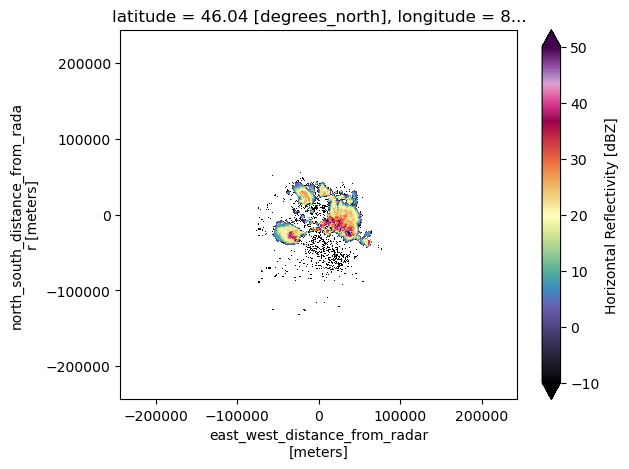

In [9]:
fig, ax = plt.subplots()
ds.isel(volume_time=1).reflectivity.plot(
                                      x="x", 
                                      y="y", 
                                      cmap="ChaseSpectral", 
                                      vmin=-10, 
                                      vmax=50)

In [13]:
ds.reflectivity.hvplot.quadmesh(x="x", 
                                y="y", 
                                groupby="volume_time", 
                                widget_type="scrubber",
                                widget_location="bottom",
                                clim=(-10, 50),
                                cmap="ChaseSpectral",
                                # rasterize=True, 
                               )

Column
    [0] HoloViews(DynamicMap, height=300, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber', width=700)
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=19, width=550)

In [11]:
erad_files = glob("/media/alfonso/drive/Laura/ERAD/20240522_MeteoSwiss_ARPA_Lombardia/Data/Cband/MonteLema*.nc")
xband_files =glob("/media/alfonso/drive/Laura/ERAD/20240522_MeteoSwiss_ARPA_Lombardia/Data/Xband/DES_VOL_RAW*.nc")
xband_files[:1]

['/media/alfonso/drive/Laura/ERAD/20240522_MeteoSwiss_ARPA_Lombardia/Data/Xband/DES_VOL_RAW_20240522_1745.nc']

In [12]:
dt_erad = xd.io.open_cfradial1_datatree(xband_files[0])

ValueError: Dimensions {'n_points'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'azimuth': 360, 'range': 416})

In [ ]:
dte